In [1]:


DATA_PATH = "Fraud.csv"
   
LIGHT_MODE = True
LIGHT_MAX_ROWS = 200000
          


TRAIN_MAX_STEP = 400  


COST_FN = 500.0   
COST_FP = 1.0    

# ==== Imports ====
import os, math, gc, sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, roc_curve, confusion_matrix,
                             classification_report)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
print("All set!")


All set!


In [2]:

# Define dtypes to cut memory use
dtypes = {
    "step": "int32",
    "type": "category",
    "amount": "float64",
    "nameOrig": "category",
    "oldbalanceOrg": "float64",
    "newbalanceOrig": "float64",
    "nameDest": "category",
    "oldbalanceDest": "float64",
    "newbalanceDest": "float64",
    "isFraud": "int8",
    "isFlaggedFraud": "int8",
}

usecols = list(dtypes.keys())

# Option A: LIGHT_MODE (fast) — read only first N rows
if LIGHT_MODE:
    print(f"LIGHT_MODE is ON. Loading up to {LIGHT_MAX_ROWS:,} rows...")
    df = pd.read_csv(DATA_PATH, dtype=dtypes, usecols=usecols, nrows=LIGHT_MAX_ROWS)
else:
    print("LIGHT_MODE is OFF. Attempting to load all rows. This may require 8–16GB+ RAM.")
    df = pd.read_csv(DATA_PATH, dtype=dtypes, usecols=usecols)

print(df.shape)
df.head()


LIGHT_MODE is ON. Loading up to 200,000 rows...
(200000, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:

print("Rows, Cols:", df.shape)
print("\nMissing values per column:\n", df.isna().sum())

fraud_rate = df["isFraud"].mean()
print(f"\nFraud rate in this slice: {fraud_rate:.6f} ({fraud_rate*100:.4f}%)")

print("\nType counts (top 10):")
print(df["type"].value_counts().head(10))

# Save a tiny sample for human inspection (first 100 rows)
sample_path = "preview_sample.csv"
df.head(100).to_csv(sample_path, index=False)
print(f"Saved a small preview to: {sample_path}")



Rows, Cols: (200000, 11)

Missing values per column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fraud rate in this slice: 0.000735 (0.0735%)

Type counts (top 10):
type
PAYMENT     73427
CASH_OUT    66488
CASH_IN     41579
TRANSFER    16836
DEBIT        1670
Name: count, dtype: int64
Saved a small preview to: preview_sample.csv


In [4]:

df = df.copy()
df["errorOrig"] = df["oldbalanceOrg"] - df["amount"] - df["newbalanceOrig"]
df["errorDest"] = df["oldbalanceDest"] + df["amount"] - df["newbalanceDest"]
df["isMerchantDest"] = df["nameDest"].astype(str).str.startswith("M").astype("int8")
df["amount_log"] = np.log1p(df["amount"])


feature_cols_num = [
    "step",
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest",
    "errorOrig",
    "errorDest",
    "amount_log",
    "isMerchantDest",
]

feature_cols_cat = ["type"]  # one-hot

target_col = "isFraud"

# Safety: drop any potential infinite values
for c in feature_cols_num:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=feature_cols_num + [target_col])
print("Data after feature engineering:", df.shape)


Data after feature engineering: (200000, 15)


In [5]:
from sklearn.model_selection import train_test_split

X = df[feature_cols_num + feature_cols_cat]
y = df[target_col]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Valid shape:", X_valid.shape, y_valid.shape)

# Free big original df if needed
del df
gc.collect()


Train shape: (140000, 11) (140000,)
Valid shape: (60000, 11) (60000,)


17

In [6]:

# Preprocess: OneHot for 'type'
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["type"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# Model 1: Logistic Regression
logreg = LogisticRegression(max_iter=200, class_weight="balanced", n_jobs=None)

pipe_log = Pipeline(steps=[("prep", preprocess), ("model", logreg)])

# Model 2: RandomForest
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    min_samples_split=4,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)

pipe_rf = Pipeline(steps=[("prep", preprocess), ("model", rf)])

# Fit both
print("Training LogisticRegression...")
pipe_log.fit(X_train, y_train)
print("Training RandomForest...")
pipe_rf.fit(X_train, y_train)

# Predict probs
valid_probs_log = pipe_log.predict_proba(X_valid)[:, 1]
valid_probs_rf  = pipe_rf.predict_proba(X_valid)[:, 1]

# Save for later use
import pickle
with open("model_logreg.pkl", "wb") as f:
    pickle.dump(pipe_log, f)
with open("model_rf.pkl", "wb") as f:
    pickle.dump(pipe_rf, f)
print("Saved trained models to current folder")



Training LogisticRegression...
Training RandomForest...
Saved trained models to current folder


Logistic — ROC AUC: 0.9356 | Average Precision: 0.1006
RandomForest — ROC AUC: 0.9885 | Average Precision: 0.9768


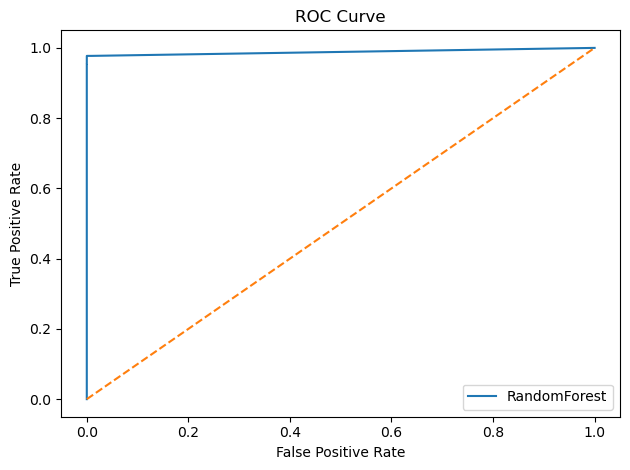

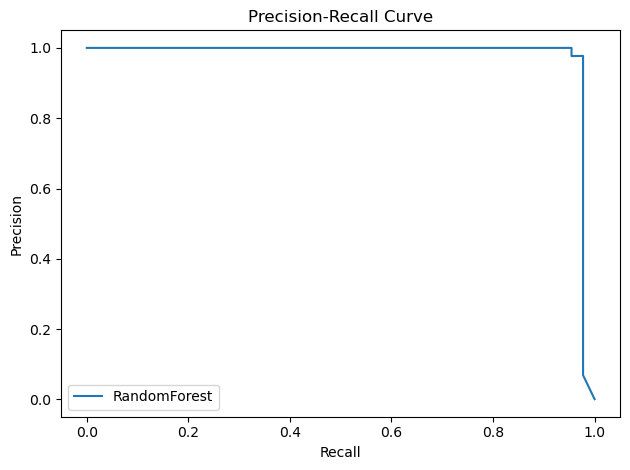

Saved plots to /mnt/data/roc_curve.png and /mnt/data/pr_curve.png


In [7]:

def print_auc_stats(y_true, y_prob, label="model"):
    roc_auc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    print(f"{label} — ROC AUC: {roc_auc:.4f} | Average Precision: {ap:.4f}")

print_auc_stats(y_valid, valid_probs_log, label="Logistic")
print_auc_stats(y_valid, valid_probs_rf,  label="RandomForest")

# Pick the better model by Average Precision
ap_log = average_precision_score(y_valid, valid_probs_log)
ap_rf = average_precision_score(y_valid, valid_probs_rf)
best_probs = valid_probs_rf if ap_rf >= ap_log else valid_probs_log
best_label = "RandomForest" if ap_rf >= ap_log else "Logistic"

# ROC curve
fpr, tpr, _ = roc_curve(y_valid, best_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"{best_label}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()

# PR curve
prec, rec, _ = precision_recall_curve(y_valid, best_probs)
plt.figure()
plt.plot(rec, prec, label=f"{best_label}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("pr_curve.png")
plt.show()

print("Saved plots to /mnt/data/roc_curve.png and /mnt/data/pr_curve.png")


In [8]:

def find_best_threshold(y_true, y_prob, cost_fn=500.0, cost_fp=1.0, grid_size=501):
    thresholds = np.linspace(0, 1, grid_size)
    best = {"thr": 0.5, "cost": float("inf"), "cm": None, "report": None}
    for thr in thresholds:
        y_pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
        total_cost = fn * cost_fn + fp * cost_fp
        if total_cost < best["cost"]:
            best.update({
                "thr": float(thr),
                "cost": float(total_cost),
                "cm": (tn, fp, fn, tp),
                "report": classification_report(y_true, y_pred, digits=4, output_dict=True)
            })
    return best

best = find_best_threshold(y_valid, best_probs, COST_FN, COST_FP, grid_size=801)
tn, fp, fn, tp = best["cm"]
print(f"Best threshold: {best['thr']:.3f}")
print(f"Total cost (@best thr): {best['cost']:.0f}")
print("Confusion matrix [tn, fp, fn, tp]:", (tn, fp, fn, tp))

# Nice printed classification report
from pprint import pprint
pprint(best["report"])

# Save predictions (with chosen threshold)
preds_path = "validation_predictions.csv"
import pandas as pd
pd.DataFrame({
    "y_valid": y_valid,
    "prob": best_probs,
    "pred": (best_probs >= best['thr']).astype(int)
}).to_csv(preds_path, index=False)
print(f"Saved validation predictions to: {preds_path}")



Best threshold: 0.128
Total cost (@best thr): 501
Confusion matrix [tn, fp, fn, tp]: (np.int64(59955), np.int64(1), np.int64(1), np.int64(43))
{'0': {'f1-score': 0.9999833211021416,
       'precision': 0.9999833211021416,
       'recall': 0.9999833211021416,
       'support': 59956.0},
 '1': {'f1-score': 0.9772727272727273,
       'precision': 0.9772727272727273,
       'recall': 0.9772727272727273,
       'support': 44.0},
 'accuracy': 0.9999666666666667,
 'macro avg': {'f1-score': 0.9886280241874345,
               'precision': 0.9886280241874345,
               'recall': 0.9886280241874345,
               'support': 60000.0},
 'weighted avg': {'f1-score': 0.9999666666666667,
                  'precision': 0.9999666666666667,
                  'recall': 0.9999666666666667,
                  'support': 60000.0}}
Saved validation predictions to: validation_predictions.csv


Computing permutation importances (this can take a minute)...
Top features:
            feature  importance
11       errorOrig    0.057717
8   newbalanceOrig    0.021150
3     type_PAYMENT    0.000033
9   oldbalanceDest    0.000006
14  isMerchantDest    0.000006
1    type_CASH_OUT    0.000000
0     type_CASH_IN    0.000000
6           amount    0.000000
5             step    0.000000
4    type_TRANSFER    0.000000
Saved all importances to: feature_importance.csv


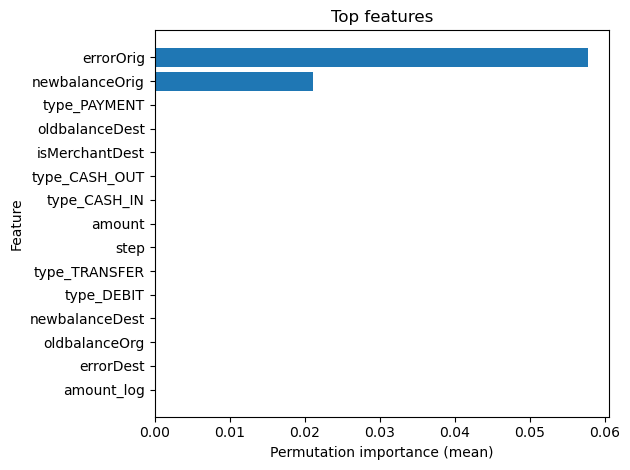

In [9]:

# Decide which model was better by AP
ap_log = average_precision_score(y_valid, valid_probs_log)
ap_rf = average_precision_score(y_valid, valid_probs_rf)
use_rf = ap_rf >= ap_log
model = pipe_rf if use_rf else pipe_log

# Build the transformed validation set to align with permutation_importance API
prep = model.named_steps["prep"]
model_est = model.named_steps["model"]
prep.fit(X_train)  # fit on train
X_valid_trans = prep.transform(X_valid)  # transform valid

# Build feature names: one-hots for 'type' + numeric remainder
cat_features = list(prep.named_transformers_["cat"].get_feature_names_out(["type"]))
feature_names = cat_features + feature_cols_num

print("Computing permutation importances (this can take a minute)...")
r = permutation_importance(model_est, X_valid_trans, y_valid, n_repeats=3, random_state=42, n_jobs=-1)

imp = pd.DataFrame({"feature": feature_names, "importance": r.importances_mean}).sort_values("importance", ascending=False)

imp_path = "feature_importance.csv"
imp.to_csv(imp_path, index=False)
print("Top features:\n", imp.head(10))
print(f"Saved all importances to: {imp_path}")

# Plot top 15
topn = 15
plt.figure()
plt.barh(imp.head(topn)["feature"][::-1], imp.head(topn)["importance"][::-1])
plt.xlabel("Permutation importance (mean)")
plt.ylabel("Feature")
plt.title("Top features")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()



## 9) Actionable plan for the business (fill in with your numbers)
Use the insights above to propose steps like:

- **Real-time rules as a first line of defense**
  - Keep the existing high-amount transfer rule (dataset has `isFlaggedFraud` > 200k). Use it to auto-block or fast-track review.
  - Add **consistency checks**: large `errorOrig` or `errorDest` values (balances that don't reconcile) => flag.
  - **Type-aware** rules (if your analysis shows fraud concentrates in certain `type` values, tighten checks there).

- **Model-driven triage**
  - Run the ML model on every transaction and **route**:
    - Score ≥ *your best threshold* → **High risk** → auto-block or manual review.
    - Score in a "grey zone" → ask for step-up verification (OTP, biometric).
    - Score < low threshold → pass but continue background monitoring.

- **Human-in-the-loop + feedback**
  - Review flagged cases daily; use the outcomes to **retrain** the model weekly.
  - Track **precision/recall** at your chosen threshold and monthly **cost savings** vs. baseline rules.

- **Monitoring**
  - **Drift checks**: watch the share of transaction types, amounts, and the model score distribution vs. training data.
  - **Alert if** fraud rate or score distribution shifts beyond set bounds; then **retrain** or re-threshold.

> Keep this section short, concrete, and linked to the metrics you computed above (AUCs, precision/recall, costs).



## 10) Appendix: Quick sanity checks & utilities


In [10]:

# Sanity check: Only use columns we intended
unexpected_cols = set(X_train.columns) - set(feature_cols_num + feature_cols_cat)
print("Unexpected columns:", unexpected_cols)
assert not unexpected_cols, "Found unexpected columns in features!"

# Save small artifacts for your report
paths = {
    "roc_curve.png": "/mnt/data/roc_curve.png",
    "pr_curve.png": "/mnt/data/pr_curve.png",
    "feature_importance.png": "/mnt/data/feature_importance.png",
    "validation_predictions.csv": "/mnt/data/validation_predictions.csv",
    "preview_sample.csv": "/mnt/data/preview_sample.csv",
}
paths


Unexpected columns: set()


{'roc_curve.png': '/mnt/data/roc_curve.png',
 'pr_curve.png': '/mnt/data/pr_curve.png',
 'feature_importance.png': '/mnt/data/feature_importance.png',
 'validation_predictions.csv': '/mnt/data/validation_predictions.csv',
 'preview_sample.csv': '/mnt/data/preview_sample.csv'}